In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import hijri_converter
from hijri_converter import convert
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import holidays
from datetime import datetime, timedelta
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# Dataset
Dataset berasal dari data harian penghasilan cargo harian berisi 6 kolom: y,date,kode_org,org,kode_des,des

In [2]:
dataset = "D://FrameworkDoRoute//PELNI//revenueDaily.xlsx"
df = pd.read_excel(dataset)
df = df.rename(columns={'tanggal': 'date'})
df = df.rename(columns={'penghasilan_muatan': 'y'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,y,date,org,kode_org,des,kode_des
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256
2,455861600.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921
...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563


# Extracting Route 
Coba bikin kolom route buat memudahkan clustering, kalau feature clustering-nya 3 : revenue,org,des masi agak bingung cara kerjanya karena org-des itu kan satu kesatuan , cuman nanti tetep di coba hasilnya sama apa beda

In [3]:
df['route'] = df['kode_org'].astype(str) + '-' + df['kode_des'].astype(str)
label_encoder = LabelEncoder()
df['route_encoded'] = label_encoder.fit_transform(df['route'])
len(df['route_encoded'].unique())

866

<Axes: >

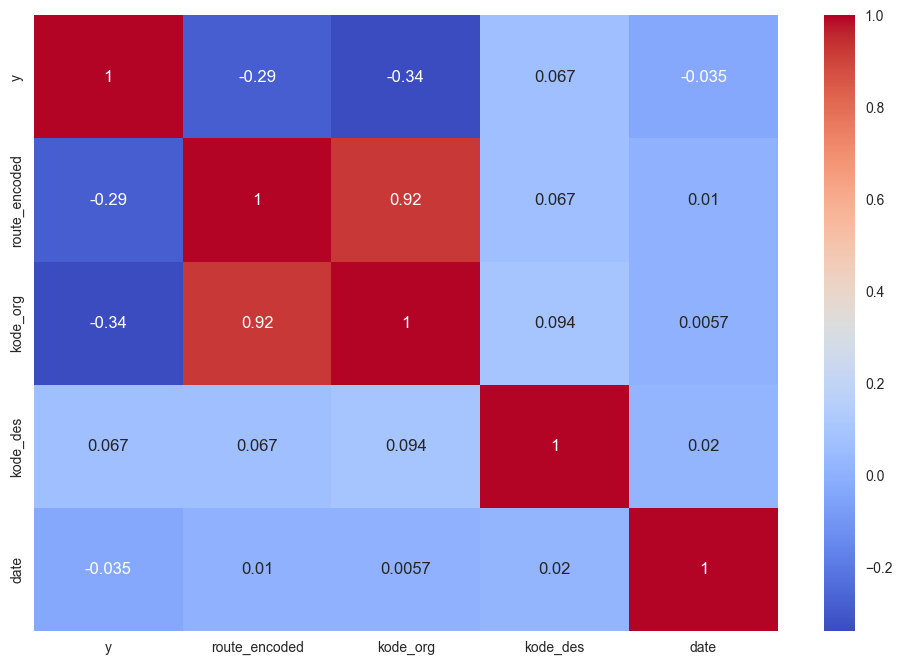

In [4]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Mengelompokkan Revenue Cargo berdasarkan rute

In [5]:
#aggregasi y(revenue/pax) jumlahnya lebih dari satu di (satu tanggal dan rute) yang sama **(optional)
route_df = df.groupby(["org","kode_org","des","kode_des","route_encoded"]).agg({"y": ["sum"]})

# Rename the columns
route_df.columns = ["total_revenue"]

# Reset the index
route_df = route_df.reset_index()
route_df

,org,kode_org,des,kode_des,route_encoded,total_revenue
0,AGATS,948,BAU-BAU,921,620,1014634.0
1,AGATS,948,KUPANG,681,618,62486.0
2,AGATS,948,MAKASSAR,893,619,1232000.0
3,AGATS,948,MERAUKE,979,621,5570975.0
4,AGATS,948,SURABAYA,563,617,1981000.0
...,...,...,...,...,...,...
861,WASIOR,981,JAYAPURA,974,825,15143480.0
862,WASIOR,981,MAKASSAR,893,822,33962331.0
863,WASIOR,981,SORONG,971,824,7568115.0
864,WASIOR,981,SURABAYA,563,821,1743000.0


# Process Clustering berdasarkan route_encoded
steps :
1. feature selection dan scaling feature
2. elbow method buat lihat rekomendasi clusternya
3. fit model
4. merge hasil ke df utama

sebelum ke steps pertama, route_df di buatkan copy supaya nilai scalingnya ga masuk ke dataframe rute, karena scaling ini cuma di pakai buat clustering untuk sementara

In [6]:
## Copy route_df
ds = route_df.copy()
columns_to_scale = ['total_revenue']

# Create a scaler object
scaler = StandardScaler()

# Apply feature scaling
ds.loc[:, columns_to_scale] = scaler.fit_transform(ds.loc[:, columns_to_scale])
ds

,org,kode_org,des,kode_des,route_encoded,total_revenue
0,AGATS,948,BAU-BAU,921,620,-0.144380
1,AGATS,948,KUPANG,681,618,-0.144587
2,AGATS,948,MAKASSAR,893,619,-0.144333
3,AGATS,948,MERAUKE,979,621,-0.143392
4,AGATS,948,SURABAYA,563,617,-0.144171
...,...,...,...,...,...,...
861,WASIOR,981,JAYAPURA,974,825,-0.141315
862,WASIOR,981,MAKASSAR,893,822,-0.137232
863,WASIOR,981,SORONG,971,824,-0.142958
864,WASIOR,981,SURABAYA,563,821,-0.144222


In [7]:
## Feature selection for clustering
features = ds[['total_revenue','route_encoded']]

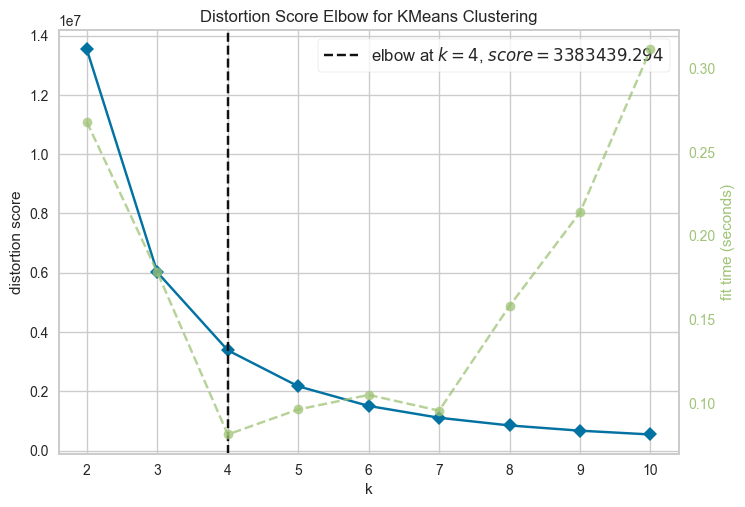

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
## nyari best N
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(features)
Elbow_M.show()

In [9]:
## clustering model + fit]
k=4
AC = AgglomerativeClustering(n_clusters=k)
# fit model and predict clusters
yhat_AC = AC.fit_predict(features)
ds['clusters'] = yhat_AC
route_df['clusters']= yhat_AC

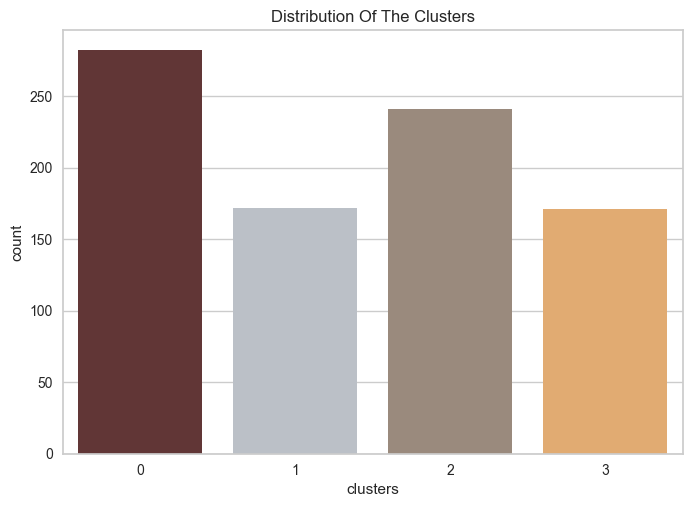

In [10]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=route_df["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

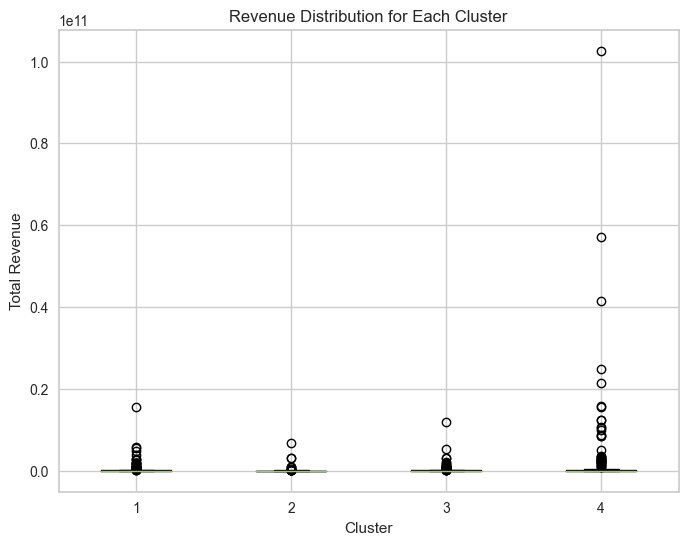

In [11]:
plt.figure(figsize=(8, 6))
plt.boxplot([route_df[route_df['clusters'] == i]['total_revenue'] for i in range(k)])
plt.xlabel('Cluster')
plt.ylabel('Total Revenue')
plt.title('Revenue Distribution for Each Cluster')
plt.show()

# coba cek feature nya total,org,des

In [12]:
features = ds[['total_revenue','kode_org','kode_des']]

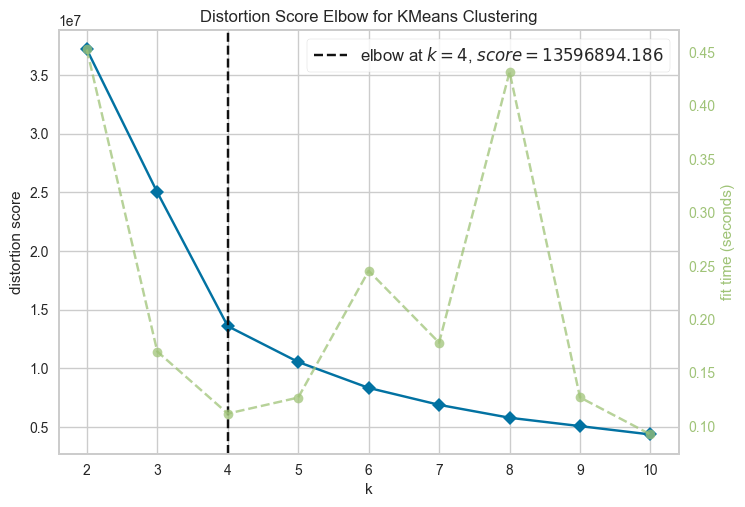

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
## nyari best N
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(features)
Elbow_M.show()

In [14]:
## clustering model + fit]
k=4
AC = AgglomerativeClustering(n_clusters=k)
# fit model and predict clusters
yhat_AC = AC.fit_predict(features)
ds['cluster_2'] = yhat_AC
route_df['clusters_2']= yhat_AC

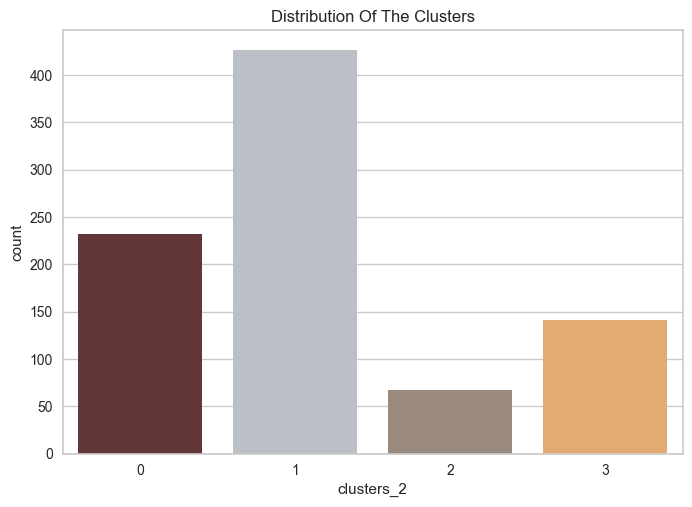

In [15]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=route_df["clusters_2"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [16]:
route_df.drop('clusters_2', axis=1, inplace=True)
ds.drop('cluster_2', axis=1, inplace=True)

# Merge clusters ke df

In [17]:
route_df

,org,kode_org,des,kode_des,route_encoded,total_revenue,clusters
0,AGATS,948,BAU-BAU,921,620,1014634.0,0
1,AGATS,948,KUPANG,681,618,62486.0,0
2,AGATS,948,MAKASSAR,893,619,1232000.0,0
3,AGATS,948,MERAUKE,979,621,5570975.0,0
4,AGATS,948,SURABAYA,563,617,1981000.0,0
...,...,...,...,...,...,...,...
861,WASIOR,981,JAYAPURA,974,825,15143480.0,2
862,WASIOR,981,MAKASSAR,893,822,33962331.0,2
863,WASIOR,981,SORONG,971,824,7568115.0,2
864,WASIOR,981,SURABAYA,563,821,1743000.0,2


In [18]:
df = df.merge(ds[['route_encoded','clusters']], on=['route_encoded'], how='left')
df

,y,date,org,kode_org,des,kode_des,route,route_encoded,clusters
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,3
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,3
2,455861600.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,3
...,...,...,...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,3
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,3
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946,973-946,731,2
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,2


<Axes: >

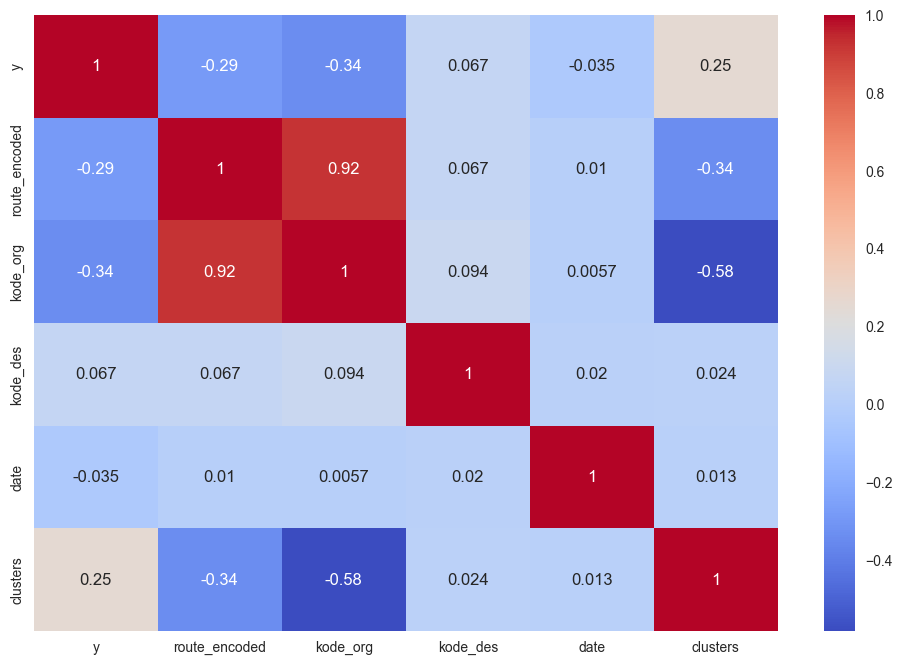

In [19]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date','clusters']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Distance Clustering 
steps masi manual :
1. buat 1 dataframe isi port (nanti bisa juga di cover backend pake master data port), step membuat:
    a. ambil semua unique value dari origin dan destination lalu masukan ke dalam kolom port
    b. dari kolom port search manual 1 1 provinsi buat nentuin regionnya berdasarkan ppt mas alfi
2. buat 1 kolom is_long yang artinya label kalau rute termasuk rute pendek/jauh (0/1)
3. bikin fungsi buat input kolom baru dengan kondisi kalau region origin dan des beda maka value 1, else 0
** nanti cara ini bisa di buat otomatis dengan extract province id dari api pelni trus bikin dataframe provinsi yang isinya province_id dan region nanti bisa tinggal select province_id_org['region'] != province_des_org['region'] return 1
** di data cargo step stepnya ga dari awal karena udah sempet nge extract data port dari data passengers, jadi tinggal read trus nambahin port yg ga ada di passengers tapi ada di cargo trus nambahin input manual kolom region buat port baru aja trus lgsg ke step 2

In [20]:
df_port_passanger = pd.read_excel('C://Users//khali//Downloads//output.xlsx')

port_set = set(route_df['kode_org'].unique())
port_list = list(port_set)

for kode_des in route_df['kode_des'].unique():
    if kode_des not in port_set:
#         print(kode_des)
        port_list.append(kode_des)
# len(port_list)
set_pname = []
for code in port_list:
#     print("port code :",code)
    for org in df[['org', 'kode_org']].drop_duplicates().values:
        if code == org[1]:
#             print(org[0])
            set_pname.append(org[0])
    for des in df[['des', 'kode_des']].drop_duplicates().values:
        if code == des[1] and des[0] not in set_pname:
#             print(des[0])
            set_pname.append(des[0])
# len(set_pname)
port_list = [[code, name] for code, name in zip(port_list, set_pname)]

In [21]:
df_port_cargo = pd.DataFrame(port_list, columns=['code', 'name'])

In [22]:
#fungsi untuk menambakah port baru di list port pasengger(sebelumnya) berdasarkan port cargo, 
#buat port baru di set nan  dlu baru input manual
def determine_cargo_reg(row):
    if row[0] in df_port_passanger['code'].values:
        return(df_port_passanger.loc[df_port_passanger['code']==row[0]]['region'].values[0])
    else: 
        return('nan')

In [23]:
df_port_cargo['region'] = df_port_cargo.apply(determine_cargo_reg, axis=1)
df_port_cargo

,code,name,region
0,256,PULAU BATAM,0
1,898,BONTANG,1
2,773,BATULICIN,1
3,266,TANJUNG BALAI KARIMUN,0
4,651,AMPENAN/LEMBAR,1
...,...,...,...
66,956,KISAR,2
67,959,MOA,2
68,958,TEPA,2
69,696,ROTE,1


In [24]:
#step 1 kelar
df_port_cargo.loc[df_port_cargo['code'] == 464, 'region'] = 0
df_port_cargo

,code,name,region
0,256,PULAU BATAM,0
1,898,BONTANG,1
2,773,BATULICIN,1
3,266,TANJUNG BALAI KARIMUN,0
4,651,AMPENAN/LEMBAR,1
...,...,...,...
66,956,KISAR,2
67,959,MOA,2
68,958,TEPA,2
69,696,ROTE,1


In [25]:
#perkondisian buat isi kolom is_long, kolom cluster distancenya

def determine_long_route(row):
    if df_port_cargo.loc[df_port_cargo['code'] == row['kode_org'], 'region'].values[0] == df_port_cargo.loc[df_port_cargo['code'] == row['kode_des'], 'region'].values[0]:
        return 0
    else:
        return 1

In [26]:
df['is_long'] = df.apply(determine_long_route, axis=1)
df

,y,date,org,kode_org,des,kode_des,route,route_encoded,clusters,is_long
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,3,0
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,3,0
2,455861600.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3,1
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3,1
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,3,1
...,...,...,...,...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,3,1
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,3,0
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946,973-946,731,2,0
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,2,1


<Axes: >

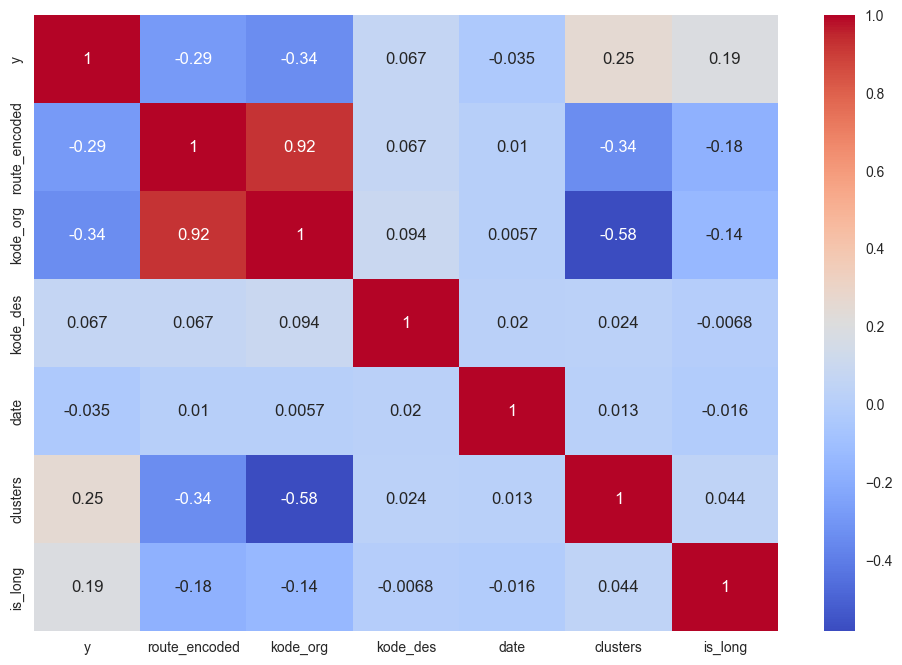

In [27]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date','clusters','is_long']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Extract Tanggal jadi sub tanggal

sebelumnya juga udah extract tanggal jadi macem macem tpi kali ini nyoba lebih fokus di day karena datanya harian dan, libur, sama tahun covid karena

In [28]:
## dataframe hari libur
id_holidays = holidays.ID(years=range(min(df.date.dt.year), max(df.date.dt.year)+1))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')

#cuti idul fitri
index = df_holidays.loc[df_holidays['event']=="Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 4):
#         print(i)
        date_before = date - timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_before}
#         print(new_row)
        df_holidays = pd.concat([df_holidays, pd.DataFrame([new_row])], ignore_index=True)

index = df_holidays.loc[df_holidays['event']=="Hari kedua dari Hari Raya Idul Fitri"].index
original_date = df_holidays.loc[index, 'day']
for date in original_date.values:
    date = pd.to_datetime(date)
#     print(date)
    for i in range(1, 3):
#         print(i)
        date_after = date + timedelta(days=i)
#         print(date_before)
        new_row = {'event': 'Cuti Hari Raya Idul Fitri', 'day': date_after}
#         print(new_row)
        df_holidays = pd.concat([df_holidays, pd.DataFrame([new_row])])

In [29]:
df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['day'] = df['date'].dt.day
# df['weekday'] = df['date'].dt.weekday

df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear

# df['weekofmonth'] = df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
# df['hijri_year'] = df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().year)
# df['hijri_month'] = gdf['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_day'] =df['date'].apply(lambda x: hijri_converter.Gregorian(x.year, x.month, x.day).to_hijri().day)

df['is_holiday']=df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
df['is_covid'] = ((df['date'] >= '2020-03-01') & (df['date'] <= '2021-12-31')).astype(int)

In [30]:
df

,y,date,org,kode_org,des,kode_des,route,route_encoded,clusters,is_long,year,day_of_week,day_of_month,day_of_year,hijri_day,is_holiday,is_covid
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,3,0,2020,4,13,318,27,0,1
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,3,0,2020,1,17,322,2,0,1
2,455861600.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3,1,2020,1,17,322,2,0,1
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3,1,2020,1,17,322,2,0,1
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,3,1,2020,1,17,322,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,3,1,2023,1,4,94,13,0,0
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,3,0,2023,2,5,95,14,0,0
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946,973-946,731,2,0,2023,2,5,95,14,0,0
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,2,1,2023,2,5,95,14,0,0


<Axes: >

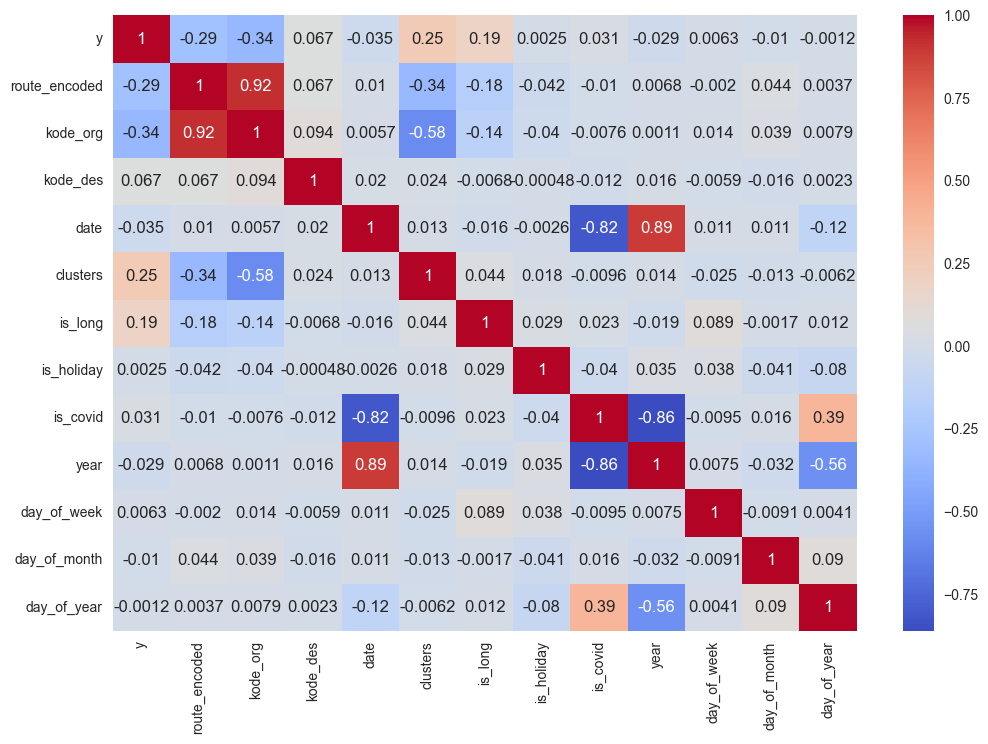

In [31]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date','clusters','is_long','is_holiday','is_covid','year','day_of_week','day_of_month','day_of_year']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Coba remove outliers 

In [32]:
from scipy import stats

# Assuming you have a DataFrame named 'df' and you want to remove outliers from the 'column_name' column
column_name = 'y'
z_scores = np.abs(stats.zscore(df[column_name]))
threshold = 3  # Adjust the threshold as needed

# Create a mask to identify outlier values
outlier_mask = z_scores > threshold

# Remove rows with outlier values
df = df[~outlier_mask]
df

,y,date,org,kode_org,des,kode_des,route,route_encoded,clusters,is_long,year,day_of_week,day_of_month,day_of_year,hijri_day,is_holiday,is_covid
0,115483600.0,2020-11-13,TANJUNG PRIOK,431,PULAU BATAM,256,431-256,44,3,0,2020,4,13,318,27,0,1
1,66148880.0,2020-11-17,BELAWAN,144,PULAU BATAM,256,144-256,1,3,0,2020,1,17,322,2,0,1
3,121340000.0,2020-11-17,TANJUNG PRIOK,431,AMBON,946,431-946,60,3,1,2020,1,17,322,2,0,1
4,161931800.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,3,1,2020,1,17,322,2,0,1
5,3896000.0,2020-11-17,TANJUNG PRIOK,431,BAU-BAU,921,431-921,57,3,1,2020,1,17,322,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,21608000.0,2023-04-04,SURABAYA,563,WAINGAPU,685,563-685,89,3,1,2023,1,4,94,13,0,0
21226,66820000.0,2023-04-05,AMPENAN/LEMBAR,651,WAINGAPU,685,651-685,147,3,0,2023,2,5,95,14,0,0
21227,45776000.0,2023-04-05,BIAK,973,AMBON,946,973-946,731,2,0,2023,2,5,95,14,0,0
21228,10000000.0,2023-04-05,BIAK,973,SURABAYA,563,973-563,726,2,1,2023,2,5,95,14,0,0


<Axes: >

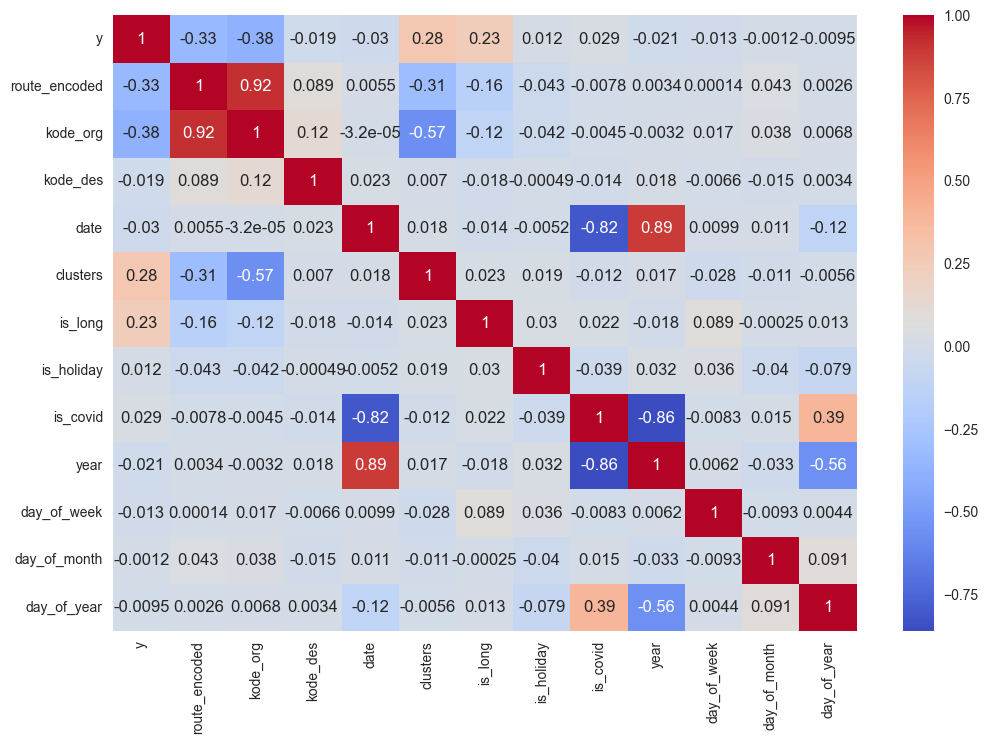

In [33]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date','clusters','is_long','is_holiday','is_covid','year','day_of_week','day_of_month','day_of_year']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Coba standard scalling total revenue

In [34]:
# from sklearn.preprocessing import StandardScaler

# # Assuming you have a DataFrame named 'df' and a list of numeric column names 'numeric_columns'
# numeric_columns = ['y']

# # Create a StandardScaler object
# scaler = StandardScaler()

# # Apply standard scaling to the numeric columns
# df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# # Print the updated DataFrame with scaled numeric columns
# df

<Axes: >

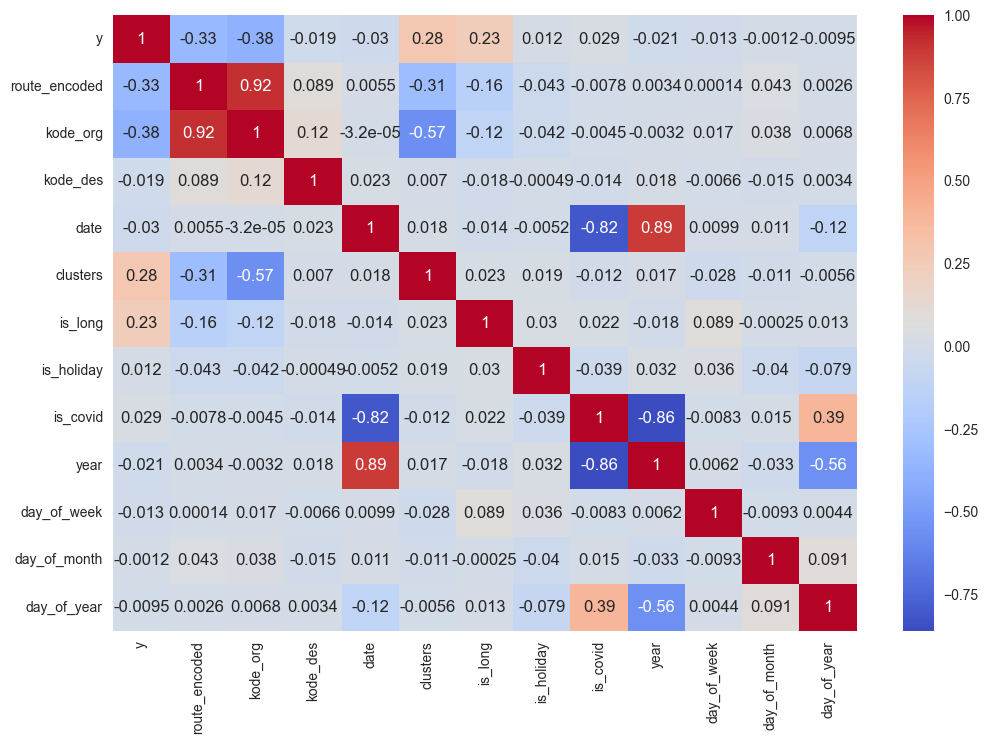

In [35]:
plt.figure(figsize=(12,8))

# Calculate the correlation matrix
corr_matrix = df[['y','route_encoded','kode_org','kode_des','date','clusters','is_long','is_holiday','is_covid','year','day_of_week','day_of_month','day_of_year']].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Scaling ga ngerubah korelasi sama sekali tapi mungkin bisa berguna buat algoritma

# Data Train + Data Test

In [36]:
#buat data test aku coba ambil 1 bulan dari rute terbanyak di cluster terbanyak (cluster 0)
for i in range(4):
    print("cluster-",i)
    
    df1 = df.loc[df['clusters']==i].loc[:,['org','kode_org','des','kode_des']].value_counts()
    print(df1)

cluster- 0
org        kode_org  des            kode_des
PARE-PARE  892       TARAKAN        808         205
MAKASSAR   893       JAYAPURA       974         194
                     SORONG         971         192
                     AMBON          946         189
BAU-BAU    921       TANJUNG PRIOK  431         158
                                               ... 
DOBO       944       SAUMLAKI       950           1
                     NAMROLE        929           1
                     KAIMANA        977           1
                     JAYAPURA       974           1
                     SORONG         971           1
Name: count, Length: 282, dtype: int64
cluster- 1
org         kode_org  des             kode_des
TARAKAN     808       PARE-PARE       892         196
KUPANG      681       MAKASSAR        893          94
WAINGAPU    685       AMPENAN/LEMBAR  651          91
MAUMERE     683       MAKASSAR        893          81
BALIKPAPAN  803       TARAKAN         808          78
     

In [37]:
#silahkan coba coba disini kalau misalnya mau ganti target ke avg bisa , mau ngurangin atau nambah features lgsg dari sini bisa
#jadi ga berkali kali ganti kolomnya
features = ['kode_org','kode_des','clusters','is_long','is_holiday','is_covid','year','day_of_week','day_of_month','day_of_year']
target = ['y']

In [1]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, TimeDistributed,BatchNormalization, Dense
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras import regularizers



data_test = df.loc[(df['kode_org'] == 431)&(df['kode_des'] == 893)]

# Split the data into features and target variable
X = data_test[features]
y = data_test[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler for normalization
scaler = MinMaxScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable separately
y_scaler = MinMaxScaler()

# Fit the scaler on the training target variable
y_scaler.fit(y_train)

# Apply the scaler to both training and test target variable
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

NameError: name 'df' is not defined

In [43]:
# Define the number of time steps, features, and lag
n_steps = 3  # Number of time steps (input sequence length)
n_features = X_train_scaled.shape[1]  # Number of features (columns)
lag = 3  # Number of lagged time steps

# Update the n_features value to include lagged features
n_features_total = n_features * (n_steps + lag)

# Create input-output pairs for training and testing with lagged features
def create_sequences(X, y, n_steps, lag):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps - lag):
        X_curr = X[i:i + n_steps]  # Extract current sequence
        X_lagged = X[i + n_steps - lag:i + n_steps]  # Extract lagged features
        X_combined = np.concatenate((X_curr, X_lagged), axis=0)  # Combine current and lagged features
        X_seq.append(X_combined)
        y_seq.append(y[i + n_steps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps, lag)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps, lag)

# Build the LSTM model
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_steps + lag, n_features), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1))

# Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=600, batch_size=64, validation_data=(X_test_seq, y_test_seq))

Epoch 1/600
3/3 [==============================] - 5s 439ms/step - loss: 0.1317 - val_loss: 0.1701
Epoch 2/600
3/3 [==============================] - 0s 149ms/step - loss: 0.0959 - val_loss: 0.0692
Epoch 3/600
3/3 [==============================] - 1s 225ms/step - loss: 0.0762 - val_loss: 0.0947
Epoch 4/600
3/3 [==============================] - 0s 176ms/step - loss: 0.0673 - val_loss: 0.0654
Epoch 5/600
3/3 [==============================] - 1s 177ms/step - loss: 0.0694 - val_loss: 0.0733
Epoch 6/600
3/3 [==============================] - 1s 240ms/step - loss: 0.0666 - val_loss: 0.0709
Epoch 7/600
3/3 [==============================] - 1s 180ms/step - loss: 0.0697 - val_loss: 0.0818
Epoch 8/600
3/3 [==============================] - 1s 195ms/step - loss: 0.0673 - val_loss: 0.0725
Epoch 9/600
3/3 [==============================] - 0s 152ms/step - loss: 0.0675 - val_loss: 0.0739
Epoch 10/600
3/3 [==============================] - 1s 191ms/step - loss: 0.0684 - val_loss: 0.0753
Epoch 11/

2/2 [==============================] - 0s 18ms/step


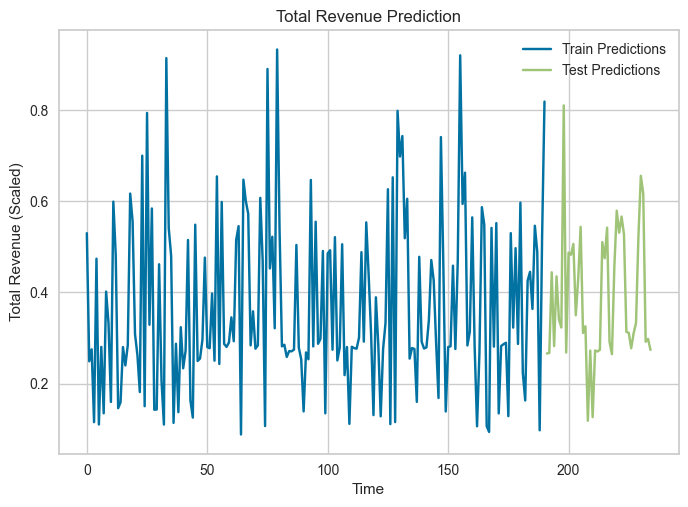

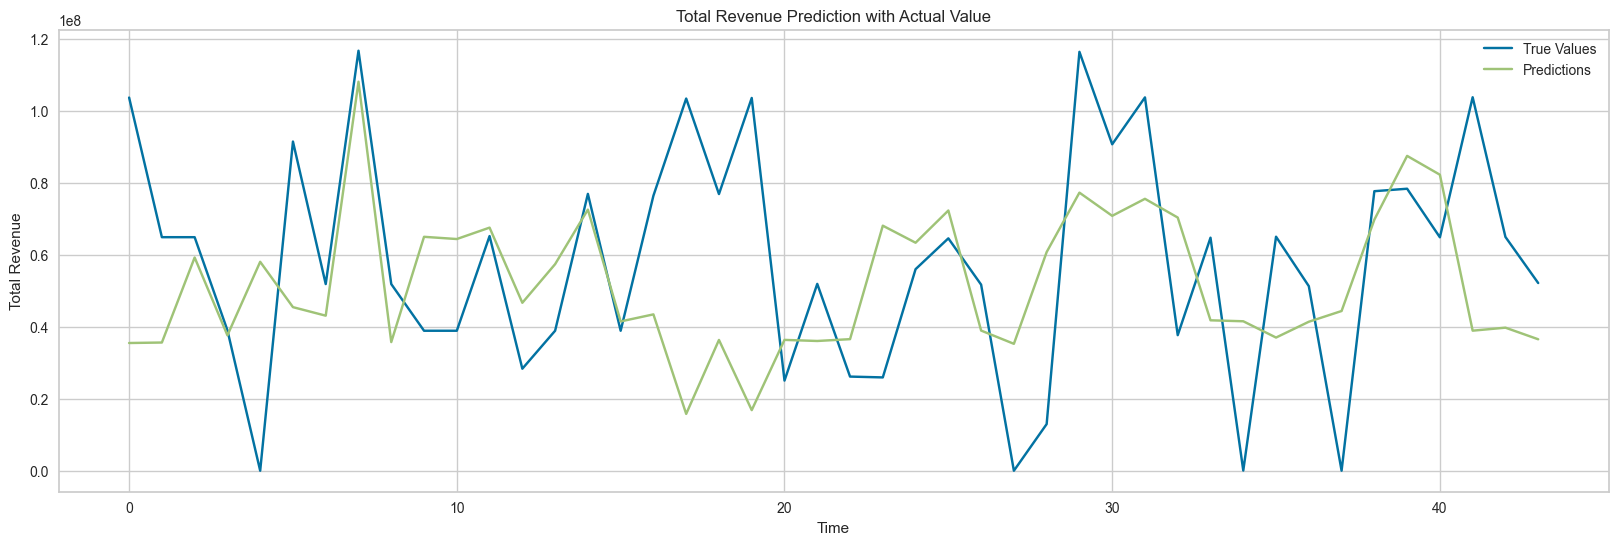

KODE_DES :  [893]
Train RMSE Value: 0.05283587664806765
Test RMSE Value: 0.25741285395003416
test original value : 58153767.63636363
R2 Score: -0.19


In [44]:
# Evaluate the model
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse transform the scaled predictions and true values
y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
y_train_true_inv = y_scaler.inverse_transform(y_train_seq)
y_test_true_inv = y_scaler.inverse_transform(y_test_seq)

#---------SCALED VALUE---------------
# Calculate the root mean squared error (RMSE) with scaled value
train_rmse = np.sqrt(np.mean((y_train_seq - y_train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test_seq - y_test_pred) ** 2))


# #---------ORIGINAL VALUE---------------
# # Calculate the root mean squared error (RMSE)
# train_rmse = np.sqrt(np.mean((y_train_true_inv - y_train_pred_inv) ** 2))
# test_rmse = np.sqrt(np.mean((y_test_true_inv - y_test_pred_inv) ** 2))


# Calculate the mean of the original values
mean_original = np.mean(y_test_true_inv)
# Calculate R2 score
r2 = r2_score(y_test_true_inv, y_test_pred_inv)

# Plot the training predictions
plt.plot(y_train_pred, label='Train Predictions')

# Plot the test predictions
plt.plot(len(y_train_pred) + np.arange(len(y_test_pred)), y_test_pred, label='Test Predictions')

plt.xlabel('Time')
plt.ylabel('Total Revenue (Scaled)')
plt.title('Total Revenue Prediction')
plt.legend()
plt.show()


# Plot the predictions
plt.figure(figsize=(20, 6))
plt.plot(y_test_true_inv, label='True Values')
plt.plot(y_test_pred_inv, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Total Revenue')
plt.title('Total Revenue Prediction with Actual Value')
plt.legend()
plt.show()

print('KODE_DES : ',data_test['kode_des'].unique())
print("Train RMSE Value:", train_rmse)
print("Test RMSE Value:", test_rmse)
print("test original value :",mean_original)
print("R2 Score: {:.2f}".format(r2))

In [41]:
# # from scikeras.wrappers import KerasRegressor
# import numpy as np
# from skopt import BayesSearchCV
# from keras.wrappers.scikit_learn import KerasRegressor

# # Define the LSTM model function
# def create_lstm_model(learning_rate, dropout_rate_1, dropout_rate_2):
#     model = Sequential()
#     model.add(LSTM(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
#     model.add(Dropout(dropout_rate_1))
#     model.add(LSTM(256, activation='relu'))
#     model.add(Dropout(dropout_rate_2))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(dropout_rate_2))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(dropout_rate_2))
#     model.add(Dense(1))
    
#     optimizer = RMSprop(learning_rate=learning_rate)
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
    
#     return model

# # Create the KerasRegressor wrapper for the LSTM model
# lstm_regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# # Define the search space for hyperparameters
# param_space = {
#     'learning_rate': (1e-6, 1e-2, 'log-uniform'),
#     'dropout_rate_1': (0.3,0.6),
#     'dropout_rate_2': (0.3,0.6)
# }

# import math

# def objective_function(params):
#     lstm_regressor.set_params(**params)
#     lstm_regressor.fit(X_train_seq, y_train_seq, epochs=600, batch_size=64, validation_data=(X_test_seq, y_test_seq))
#     y_pred = lstm_regressor.predict(X_test_seq)
#     mse = mean_squared_error(y_test_seq, y_pred)
#     rmse = math.sqrt(mse)
#     return rmse

# # Perform Bayesian optimization
# bayes_cv_tuner = BayesSearchCV(
#     estimator=lstm_regressor,
#     search_spaces=param_space,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     n_iter=50,  # Number of iterations for the search
#     cv=3,
#     refit=True,
#     random_state=42
# )

# result = bayes_cv_tuner.fit(X_train_seq, y_train_seq)


ValueError: in user code:

    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\khali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 3, 10), found shape=(None, 6, 10)


In [ ]:
# best_params = result.best_params_
# best_model = result.best_estimator_

# print("Best MSE:", -result.best_score_)
# print("Best Hyperparameters:", best_params)

NameError: name 'result' is not defined

In [ ]:
# # Use the best model to make predictions
# y_pred = best_model.predict(X_test_seq)

# # Reshape the predicted values
# y_pred = y_pred.reshape(-1, 1)

# # Inverse transform the scaled predictions and actual values
# y_pred_actual = y_scaler.inverse_transform(y_pred)
# y_test_actual = y_scaler.inverse_transform(y_test_seq)

# # Plot the predicted values and actual values
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_actual, label='Actual')
# plt.plot(y_pred_actual, label='Predicted')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted')
# plt.legend()
# plt.show()